# 3K2F G-ADSA Analysis

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of polypropylene glycol (PPG), a difunctional polyol from Sigma-Aldrich with molecular weight ~2700 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from June 17-24, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 31.1 C.

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit
import dataproc
import errprop
import plot

from importlib import reload
reload(dataproc)
reload(errprop)


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190617_0621_3k2f_31c_adsa_volume.csv']
# list of data files with interfacial tension data
adsa_if_tension_file_list = ['20190617_0621_3k2f_31c_adsa_if_tension.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../../EXPERIMENTS/Italy/data/gravimetry/3k2f_31c-TRD-061719-1147.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '3k2f_31c.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 6/17 11:48:28am; adsa video 6/17 11:53am
adsa_t0_list = [60*4 + 32]
# number of measurements to average for surface tension and volume readings
n_adsa = 10

# polyol code name
polyol = '3k2f'
# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.731
# density of polyol sample at atmospheric pressure and 25 C (SDS) [g/mL]
rho_samp_atm = 1.004 
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]
v_drop_atm = 4.688 # volume of drop at atmospheric pressure; from 20190617_3k2f_1bar_snapshot.mdb [uL]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = np.array([0, 50, 100, 200, 550, 1050, 1500, 2000, 2500, 3000, 3500, 4000, 4450,
                       4950, 5400, 4650, 3900, 3200, 2450]) # the lower pressures lack ADSA data, data at 5400 has inaccurate ADSA
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# number of measurements of pressure within equilibrium (300 s, every 30 s)
n_p_eq = 10

# CONSTANTS
# Set-point temperature [C]
T = 31.1
# atmospheric pressure [kPa]
P_ATM = 101.3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = br_cruc + dataproc.rho_co2(P_ATM, T)*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [2]:
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, \
                                                                                      adsa_t0_list, grav_file_path, p_set_arr)
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 0 kPa.
Rejected 1 outliers.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Drop volume = 4.678300 uL.
Pressure = 50 kPa.
********not enough ADSA points at given pressure.******
Drop volume = 4.693400 uL.
Pressure = 100 kPa.
Drop volume = 4.707600 uL.
Pressure = 200 kPa.
Rejected 1 outliers.
Drop volume = 4.728300 uL.
Pressure = 550 kPa.
Drop volume = 4.766500 uL.
Pressure = 1050 kPa.
Rejected 1 outliers.
Drop volume = 4.810000 uL.
Pressure = 1500 kPa.
Rejected 1 outliers.
Drop volume = 4.910400 uL.
Pressure = 2000 kPa.
Rejected 1 outliers.
Drop volume = 4.990900 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.
Drop volume = 5.099900 uL.
Pressure = 3000 kPa.
Rejected 1 outliers.
Drop volume = 5.195700 uL.
Pressure = 3500 kPa.
Rejected 1 outliers.
Drop volume = 5.333400 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.
Drop volume = 5.466900 uL.
Pressure = 4450 kPa.
Rejected 1 outliers.
Drop volume = 5.600000 uL.
Pressure = 4950 kPa.
Rejected 1 outliers.
Drop volume = 5.717100 uL.
Pressure = 5400 kPa.
Rejected 1 outliers.
Drop volume = 5.835400 uL.
Pressure = 4650 kPa

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,0,0.4444,0.151969,0.00105,1e-05,8.01983,1e-05,27.7414,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50,49.8799,0.0481465,0.00025,1e-05,8.01667,1e-05,27.7345,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,101.797,0.0298838,-0.000635,1e-05,8.0139,1e-05,27.7278,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200,201.98,0,-0.00235,1e-05,8.00902,1e-05,27.7152,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,549.588,0.0428,-0.00836,1e-05,7.99175,1e-05,27.6706,1e-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


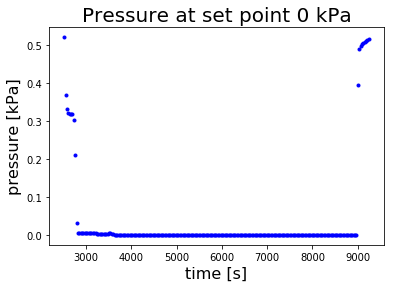

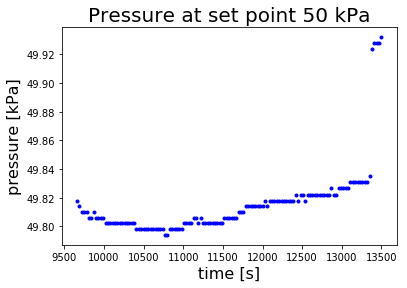

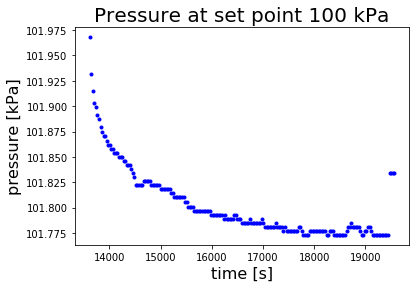

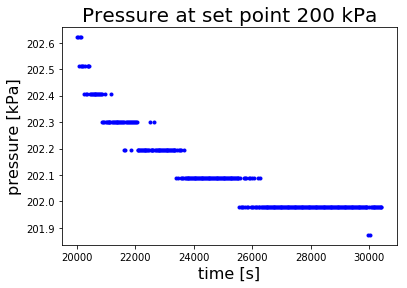

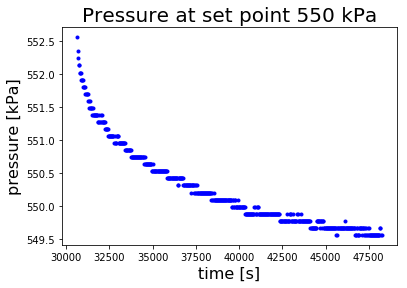

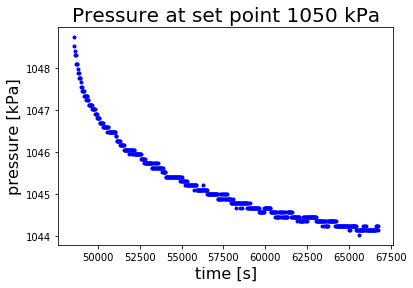

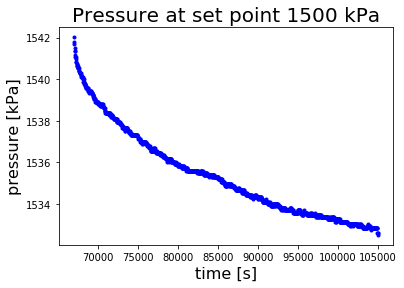

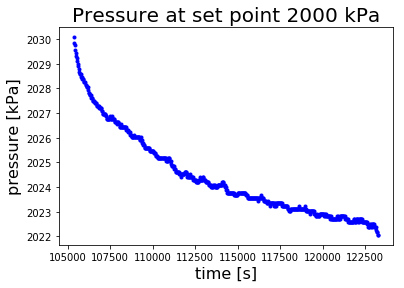

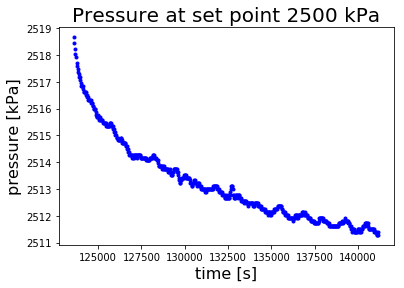

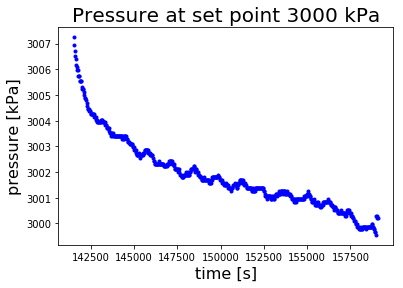

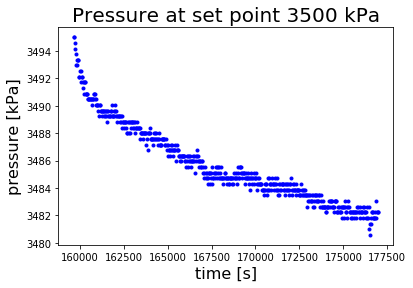

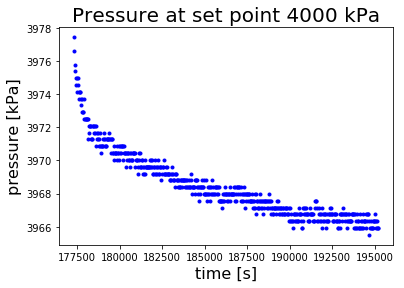

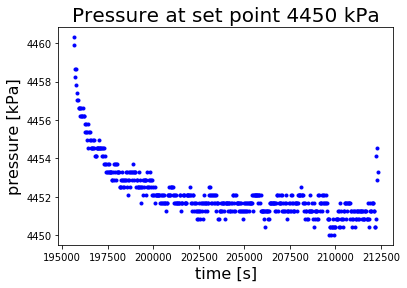

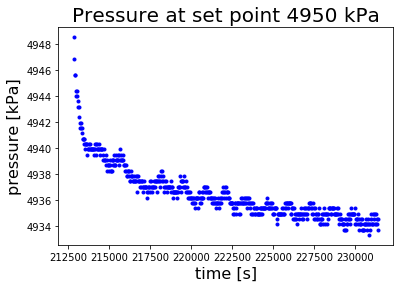

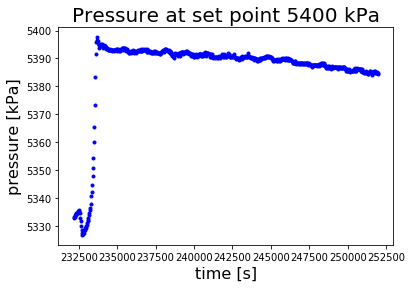

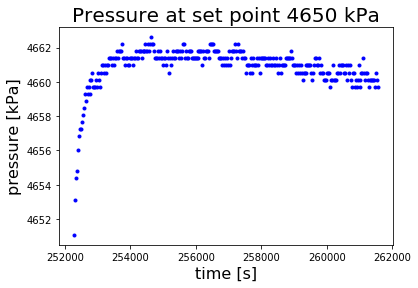

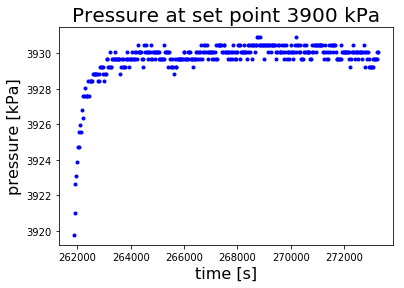

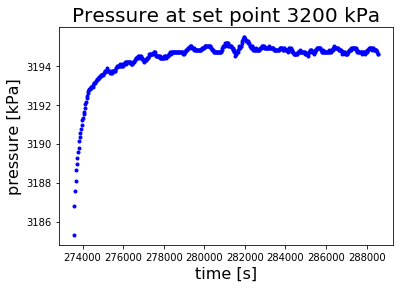

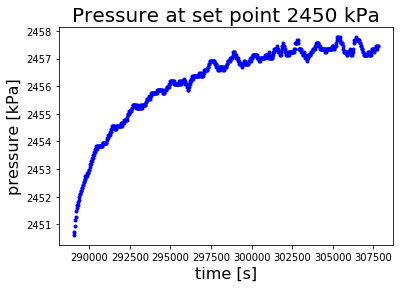

In [3]:
reload(dataproc)

# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization
# initalize marker for pressure bounds
i_p1 = 0
focus_on_step = False
select_index = 10
plot_p = True
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = np.std(p_eq)

    if focus_on_step:
        i_p -= 20
        
        if i != select_index:
            continue
    if plot_p:
        # PLOT PRESSURE TO DEBUG IDENTIFICATION OF PRESSURE STEPS
        plot.plot_line(t_grav[i_p0:i_p1], p_arr[i_p0:i_p1], xlabel='time [s]', ylabel='pressure [kPa]',
                 title='Pressure at set point {0} kPa'.format(p_set))
        if focus_on_step:
            ax.set_xlim([220000, 250000])
            ax.set_ylim([4800, 4950])

    # store results in data frame
    df = dataproc.store_grav_adsa(df, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_adsa)

df.head()

**As for the 1k2f 30 C experiment, the pressure had a strange shape at the beginning of the rise to 5500 kPa, this time starting low, jumping up, and then slowly decreasing.**
However, in general the pressure remained within 10 kPa of the average value (which was not necessarily the set value).

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must comptue the mass and volume of the polymer under vacuum.

In [4]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# (extract value at 0 pressure) [g]
br_eq_0 = br_eq[0]
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df['dissolved gas balance reading [g]'] = br_gas

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere with linear interpolation--index 2 corresponds to ~100 kPa [g]
w_gas_atm = br_gas[2] + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_drop_0 = v_drop[0] # drop volume under vacuum [uL]
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 0.729943 g vs. mass of polymer at atmospheric pressure = 0.731000 g.
Dry polymer mass estimated using tare measurement = 0.7362670455932383 g.
Volume of dry polymer in crucible is approximately ~ 0.721720 mL (using atmospheric density).


### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

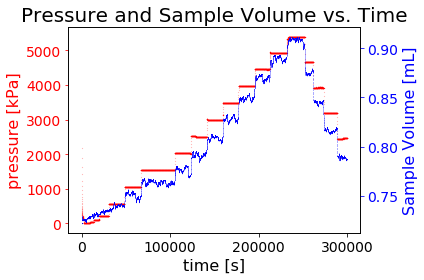

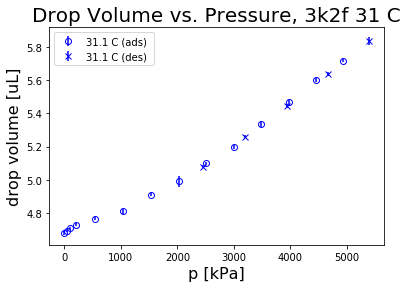

In [5]:
reload(plot)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# compute live change in volume
v_samp_adsa = v_drop / v_drop_atm * v_samp_atm
v_samp_grav = np.interp(t_grav, t_adsa, v_samp_adsa)
i_t_500k = t_grav < 3E5
plot.plot_two_axes(t_grav[i_t_500k], p_arr[i_t_500k], v_samp_grav[i_t_500k], labels=[r'$p$', r'$V_{samp}$'], xlabel='time [s]', 
                   ms=0.1, ylabels=['pressure [kPa]', 'Sample Volume [mL]'], title='Pressure and Sample Volume vs. Time')

# extract data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
s_drop_vol = df['drop volume std [uL]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))

if save_plots:
    plt.savefig(save_folder + 'drop_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Fitting Drop Volume to Quadratic Curve to Reduce Error in Specific Volume

Prof. Di Maio suggested fitting the drop volume to a quadratic curve to reduce uncertainty introduced by experimental errors. By reducing uncertainty in the drop volume, we will reduce the error in the sample volume, and thus in the specific volume measurement, which is too high to distinguish any non-monotonic trend in the pressure that we might expect (a variation of about 5% based on the PCL/CO2 paper by Carbone et al. (2012) *J. Supercrit. Fl.*

This method greatly reduces the statistical error but the errors are smaller than the systematic error.

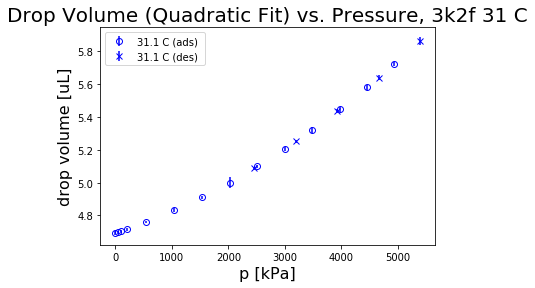

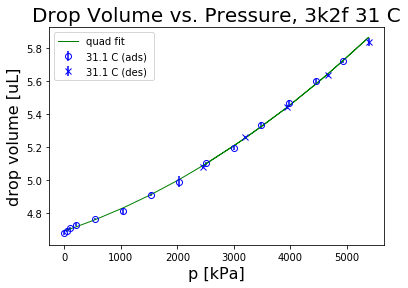

In [6]:
# remove nans
inds_not_nan = np.logical_not(np.isnan(s_drop_vol))
p_plot_2_fit = p_plot[inds_not_nan]
v_drop_eq_2_fit = v_drop_eq[inds_not_nan]
s_drop_vol_2_fit = s_drop_vol[inds_not_nan]

# fit drop volume vs. pressure with quadratic fit
i_sort = np.argsort(p_plot[1:])
coeffs, Cov = np.polyfit(p_plot_2_fit, v_drop_eq_2_fit, 2, w=1/s_drop_vol_2_fit, cov=True)
a, b, c = coeffs

def drop_vol_fit(p, a=a, b=b, c=c):
    drop_vol = a*p**2 + b*p + c
    return drop_vol

v_drop_fit = drop_vol_fit(p_plot)


# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_fit, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume (Quadratic Fit) vs. Pressure, %s %d C' % (polyol, T))

# plot equilibrium drop volume vs. p alongside the fit (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_plot, v_drop_fit, ax=ax, marker=None, lw=1, color='g', label='quad fit')
plt.legend()

# Use fitted drop volume to estimate the sample volume
v_samp_fit = v_drop_fit / v_drop_atm * v_samp_atm


### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [7]:
reload(errprop)

# set parameters for error propagation
n = len(p_set_arr)
w_poly_arr = w_poly*np.ones([n])
s_v_drop = df['drop volume std [uL]'].to_numpy(dtype=float)
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_eq[-2]*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop[-2]*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)
s_zero = df['zero std [g]'].to_numpy(dtype=float)
s_w_gas_ref = 0.00001*np.ones([n]) # ??? [g]

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

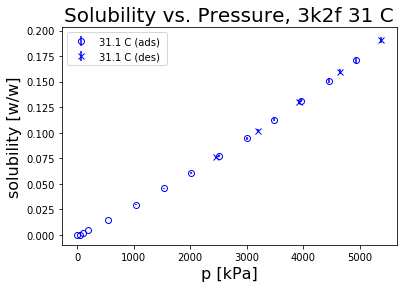

In [8]:
# COMPUTE AND PLOT SOLUBILITY
reload(errprop)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
df['sample volume [mL]'] = v_samp

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_buoy = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float), T)*(v_samp + v_ref_he)
df['buoyancy correction [g]'] = w_buoy
w_gas_act = br_gas + w_buoy
df['actual weight of dissolved gas [g]'] = w_gas_act
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility, v_samp, w_buoy, w_gas_act, v_drop_eq, 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Literature Data

Since there are data in the literature from Guadagno and Kazarian (2004) *JPCB*, we will plot their results alongside ours. They took measurements of 2700 g/mol PPG with FTIR at 25 C and 35 C.

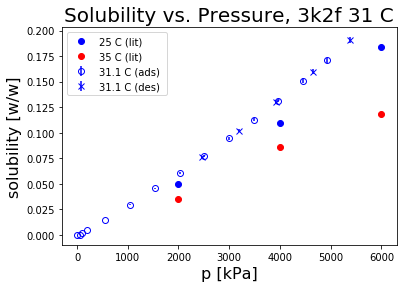

In [9]:
# plot data from Guadagno and Kazarian (2004) JPCB at 25 C and 35 C
p_lit = np.array([2000, 4000, 6000])
solubility_lit_25 = np.array([0.05, 0.11, 0.184])
solubility_lit_35 = np.array([0.035, 0.086, 0.118])

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='b', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_lit, solubility_lit_25, ax=ax, marker='o', color='b', label='25 C (lit)')
ax = plot.plot_line(p_lit, solubility_lit_35, ax=ax, marker='o', color='r', label='35 C (lit)')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_lit_data.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Solubility for Different Molecular Weights

We now have data for solubility at similar temperatures (difference of 0.6 C) for similar polyols at different molecular weights (1000 g/mol for 1k2f and 2700 g/mol for 3k2f), so we will plot them together for comparison.

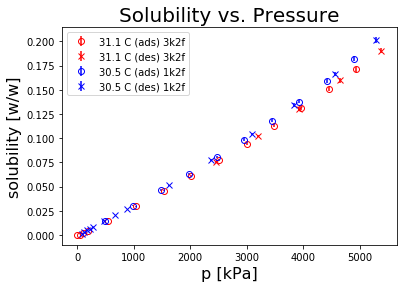

In [10]:
reload(plot)
# Load data from 1k2f 30.5 C data
df_1k2f = pd.read_csv(save_folder + '1k2f_30c.csv')
p_1k2f = df_1k2f['p actual [kPa]'].to_numpy(dtype=float)
solubility_1k2f = df_1k2f['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_1k2f = df_1k2f['solubility error [w/w]'].to_numpy(dtype=float)

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, 31.1, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure', label_tag='3k2f')
ax = plot.plot_errorbars_ads_des(p_1k2f, solubility_1k2f, s_solubility_1k2f, p_1k2f, 30.5, ax=ax, color='b', label_tag='1k2f')

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_%s_%dc.pdf' % (polyol, T, '1k2f', 30), bbox_inches='tight')

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

(0.95, 1.05)

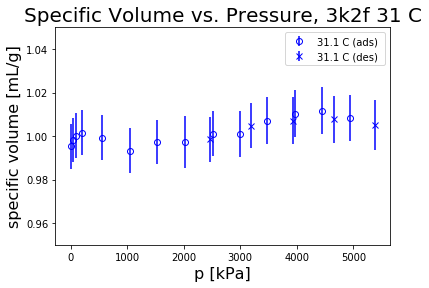

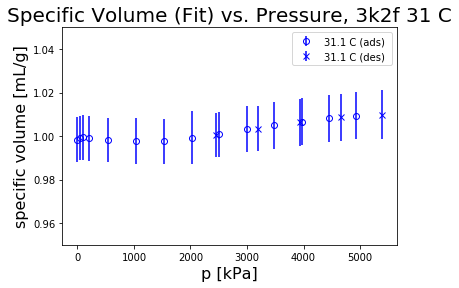

In [11]:
reload(errprop)

# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol
# also compute the specific volume based on the quadratic fit of the drop volume
spec_vol_fit = v_samp_fit / (w_gas_act + w_poly)

# propagate error to estimate uncertainty
s_spec_vol = errprop.error_spec_vol(spec_vol, v_samp, w_buoy, w_gas_act, v_drop_eq, 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['specific volume error [mL/g]'] = s_spec_vol

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.95, 1.05])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol_fit, s_spec_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                             ylabel='specific volume [mL/g]', title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([0.95, 1.05])

Having computed the specific volume, we store it as the sample density along with the density of the carbon dioxide atmosphere for use in FTA32 software to compute the interfacial tension properly.

In [12]:
reload(dataproc)
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('adsa')] + 'adsa_densities.csv', index=False)

#### Plotting mass of absorbed gas over time

For visual analysis, we plot the absorption of gas over time alongside the pressure

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 1800 and t_f = 9240
Pressure = 50 kPa.
t_i = 9240 and t_f = 13500
Pressure = 100 kPa.
t_i = 13500 and t_f = 19560
Pressure = 200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 19560 and t_f = 30420
Pressure = 550 kPa.
t_i = 30420 and t_f = 48240
Pressure = 1050 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 48240 and t_f = 66750
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 66750 and t_f = 105060
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 105060 and t_f = 123270
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 123270 and t_f = 141180
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 141180 and t_f = 159090
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 159090 and t_f = 176970
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
t_i = 176970 and t_f = 195210
Pressure = 4450 kPa.
Rejected 1 ou

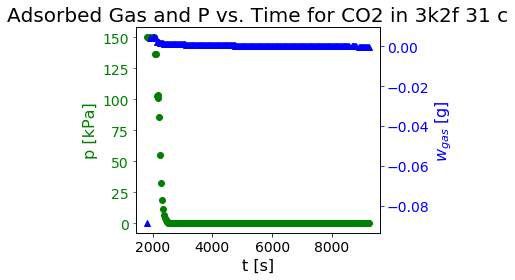

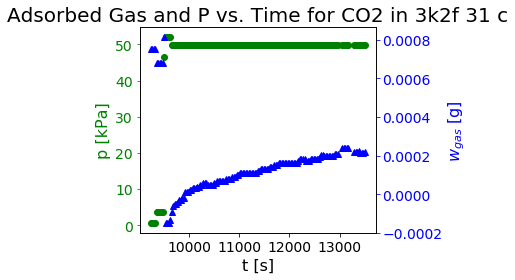

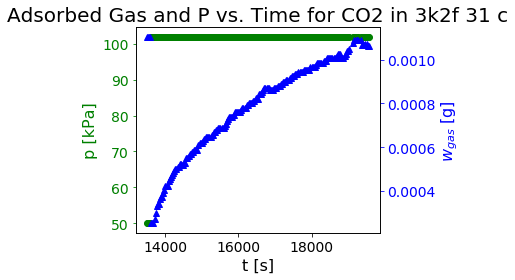

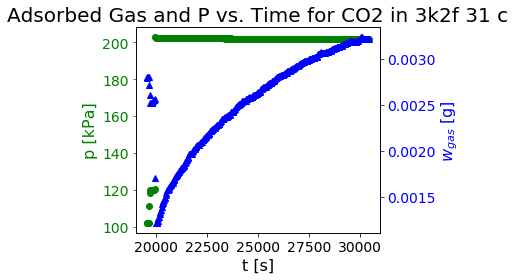

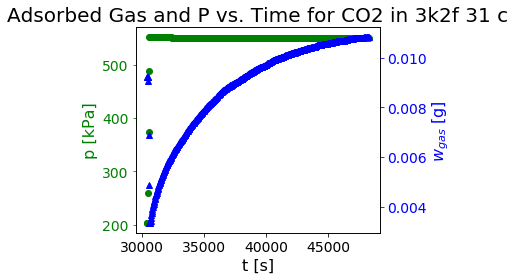

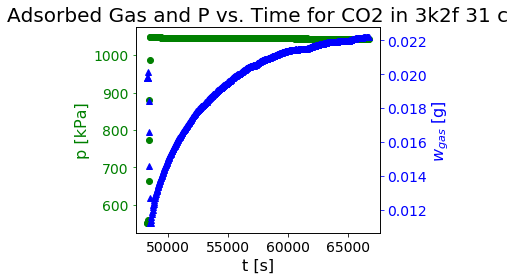

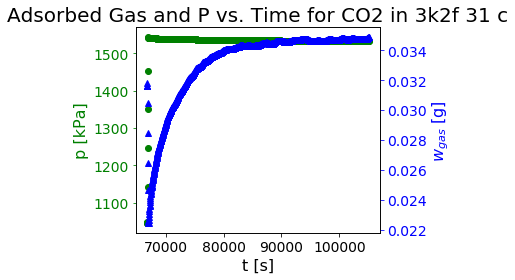

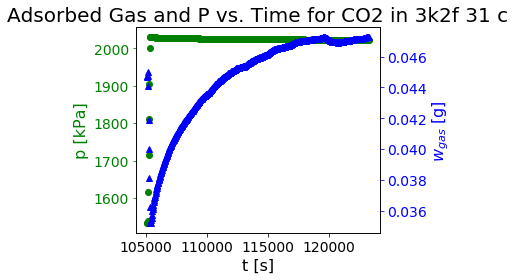

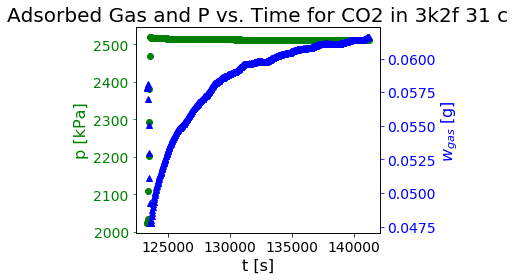

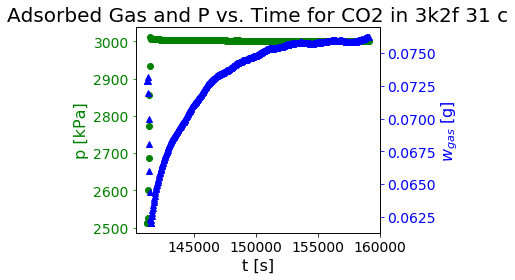

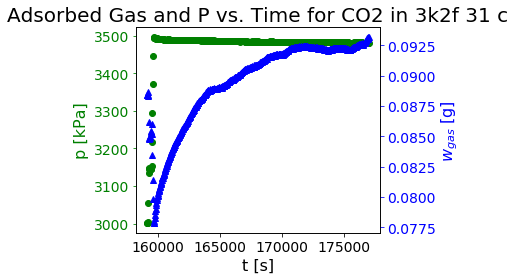

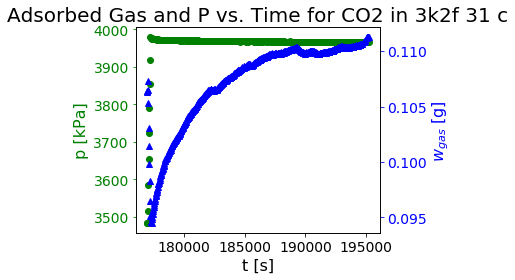

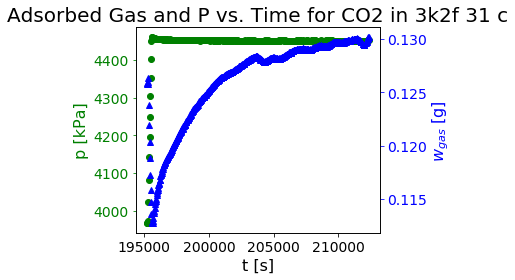

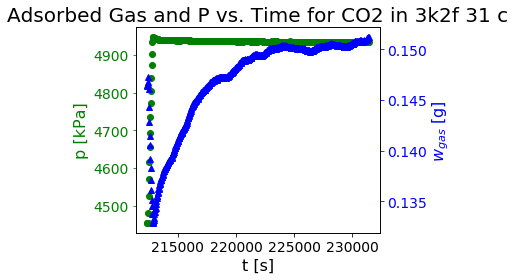

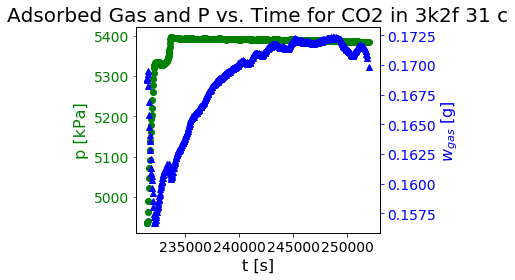

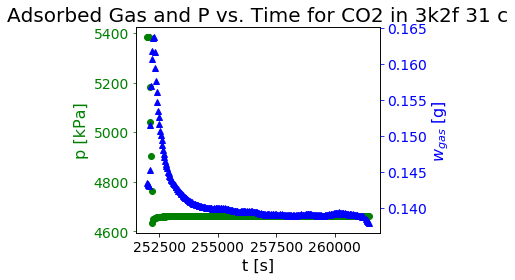

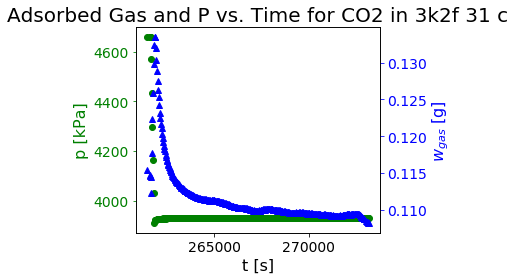

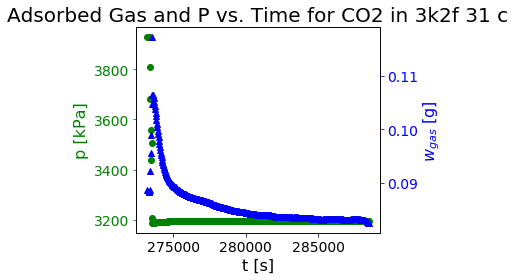

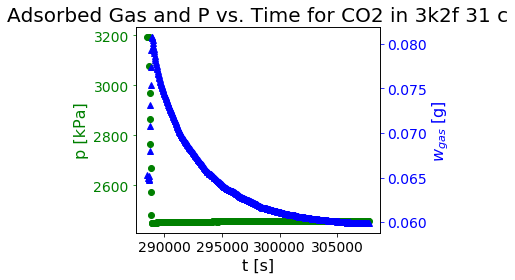

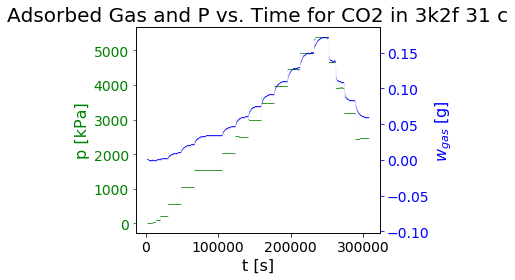

In [13]:
from scipy.signal import medfilt
reload(dataproc)

# Set plot parameters
lw = 2
ax_fs = 16
t_fs = 20
tk_fs = 14
colors = ['g', 'b']
line_styles = ['--',  '-']
ms = 0.01
x_lim = [80000, 400000]
y_lim = [7.88, 7.9]

i_p0_temp = 0
i_p1_temp = 0
# initalize marker for pressure bounds
last_bound = 0
# initialize array to store p, t, and gas weight for plotting
w_gas_2_plot = np.array([])
p_2_plot = np.array([])
t_2_plot = np.array([])
# initialize mass of gas from end of previous pressure step as initial mass M_0 [g]
M_0_prev = np.zeros([len(p_set_arr)])
# initialize array of mass of gas at equilibrium using last mass of current pressure step [g]
M_infty_final = np.zeros([len(p_set_arr)])
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    i_p0 = i_p0_temp
    # update last bound
    last_bound = i_p1_temp
    # compute mass of adsorbed gas
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True, v_samp_live=v_samp_grav, no_gaps=True)
    w_gas_act_eq = np.mean(w_gas_act[-n_p_eq:])
    # save gas mass from current run for next M_0
    if i < len(p_set_arr)-1:
        M_0_prev[i+1] = w_gas_act_eq
    # save gas mass from current run for current M_infty
    M_infty_final[i] = w_gas_act_eq
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue
        
    # append data for plotting
    w_gas_2_plot = np.append(w_gas_2_plot, w_gas_act)
    p_2_plot = np.append(p_2_plot, p_mp1)
    t_2_plot = np.append(t_2_plot, t_mp1)


    # Plot adsorbed gas and pressure over time
    ax = plot.plot_two_axes(t_mp1, p_mp1, w_gas_act, markers=['o', '^'], xlabel='t [s]', 
                        ylabels=['p [kPa]', r'$w_{gas}$ [g]'], ms=6,
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=colors)
    
    ### *** TODO -- figure out why mass data points are going in the wrong direction at the beginning ***
    print('t_i = {0} and t_f = {1}'.format(t_mp1[0], t_mp1[-1]))
    
    ### ***
    i_p0_temp = np.where(t_grav==t_mp1[0])[0][0]
    i_p1_temp = np.where(t_grav==t_mp1[-1])[0][0]
    
# save initial mass estimated using previous gas mass [g]
df['M_0 (prev) [g]'] = M_0_prev
# save final gas mass [g]
df['M_infty (final) [g]'] = M_infty_final

# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_2_plot, p_2_plot, w_gas_2_plot, markers=['o', '^'], xlabel='t [s]', 
                        ylabels=['p [kPa]', r'$w_{gas}$ [g]'],
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=colors, ms=ms)

# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Interfacial Tension

At this point, I use the program auto_density_input_fta32.py to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

Pressure = 0 kPa.
Rejected 1 outliers.
Interfacial tension = 29.125000 mN/m.
Pressure = 50 kPa.
********not enough ADSA points at given pressure.******
Interfacial tension data not stored.
Pressure = 100 kPa.
Interfacial tension = 28.692000 mN/m.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 200 kPa.
Rejected 1 outliers.
Interfacial tension = 28.341000 mN/m.
Pressure = 550 kPa.
Interfacial tension = 27.287000 mN/m.
Pressure = 1050 kPa.
Rejected 1 outliers.
Interfacial tension = 25.712000 mN/m.
Pressure = 1500 kPa.
Rejected 1 outliers.
Interfacial tension = 24.181000 mN/m.
Pressure = 2000 kPa.
Rejected 1 outliers.
Interfacial tension = 22.545000 mN/m.
Pressure = 2500 kPa.
Rejected 1 outliers.
Interfacial tension = 20.957000 mN/m.
Pressure = 3000 kPa.
Rejected 1 outliers.
Interfacial tension = 19.349000 mN/m.
Pressure = 3500 kPa.
Rejected 1 outliers.
Interfacial tension = 17.658000 mN/m.
Pressure = 4000 kPa.
Rejected 1 outliers.
Interfacial tension = 16.056000 mN/m.
Pressure = 4450 kPa.
Rejected 1 outliers.
Interfacial tension = 14.411000 mN/m.
Pressure = 4950 kPa.
Rejected 1 outliers.
Interfacial tension = 12.822000 mN/m.
Pressure = 5400 kPa.
Rejected 1 outliers.
Interfacial tension = 11.243000 mN/m.
Pressure = 4650 kPa.
Rejected 1 outliers.
Interfacial tension =

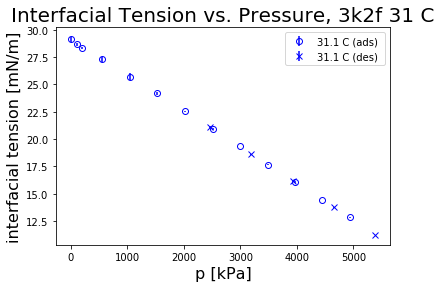

In [14]:
reload(dataproc)
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        p_set = p_set_arr[i]
        print('Pressure = %d kPa.' % p_set)
        # get indices of each measurement with pressure within thresholds
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
        df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)

    # save results
    df.to_csv(save_folder + save_data_name)

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Compare Interfacial Tension vs. Molecular Weight

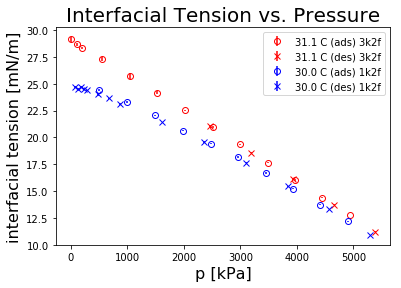

In [15]:
reload(plot)
# has interfacial tension data been provided?
if len(if_tension) > 0:
    
    # extract data to plot
    df_1k2f = pd.read_csv(save_folder + '1k2f_30c.csv')
    if_tension_3k2f = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension_3k2f = df['if tension std [mN/m]'].to_numpy(dtype=float)
    p_1k2f = df_1k2f['p actual [kPa]'].to_numpy(dtype=float)
    if_tension_1k2f = df_1k2f['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension_1k2f = df_1k2f['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_3k2f, s_if_tension_3k2f, p_plot, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure', label_tag='3k2f')
    ax = plot.plot_errorbars_ads_des(p_1k2f, if_tension_1k2f, s_if_tension_1k2f, p_1k2f, 30, ax=ax, color='b', 
                                    label_tag='1k2f')

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc_1k2f_30c.pdf' % (polyol, T), bbox_inches='tight')

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

**NOTE THAT I SWITCH $t_0$ and $t_0^{fit}$**

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 2.68e-02 cm^2/s.
Pressure = 50 kPa.
D_sqrt = 6.12e-05 cm^2/s.
Pressure = 100 kPa.
D_sqrt = 1.06e-05 cm^2/s.
Pressure = 200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:690: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b


D_sqrt = 6.99e-06 cm^2/s.
Pressure = 550 kPa.
D_sqrt = 7.26e-06 cm^2/s.
Pressure = 1050 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 7.45e-06 cm^2/s.
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 7.90e-06 cm^2/s.
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 9.99e-06 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 9.59e-06 cm^2/s.
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.13e-05 cm^2/s.
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 9.67e-06 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.08e-05 cm^2/s.
Pressure = 4450 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.10e-05 cm^2/s.
Pressure = 4950 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.03e-05 cm^2/s.
Pressure = 5400 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.19e-05 cm^2/s.
Pressure = 4650 kPa.
Rejected 1 outlie

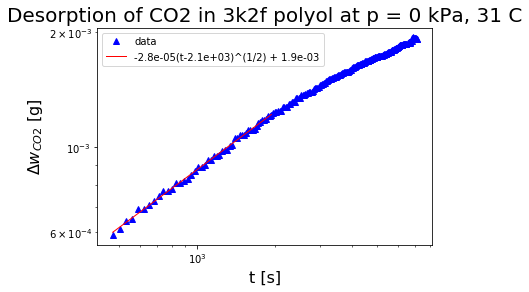

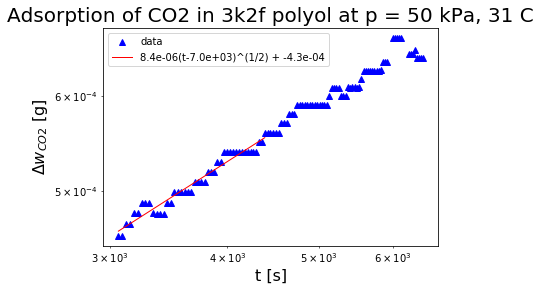

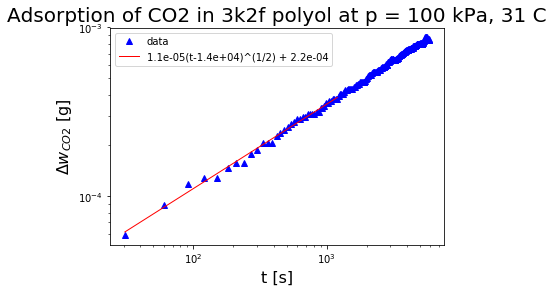

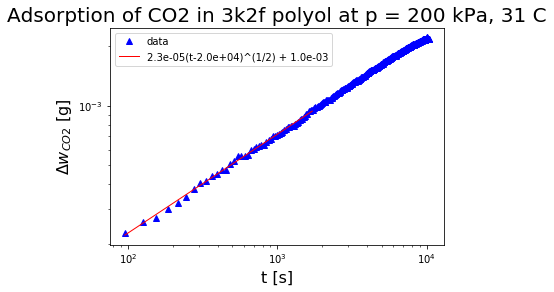

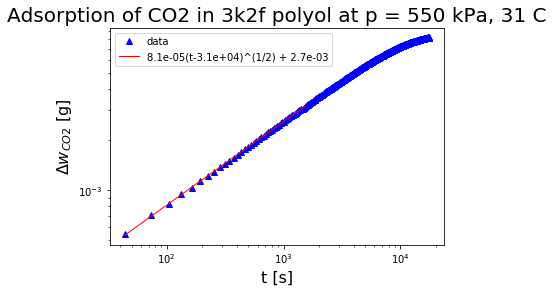

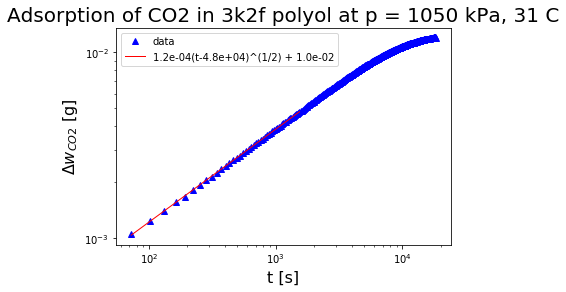

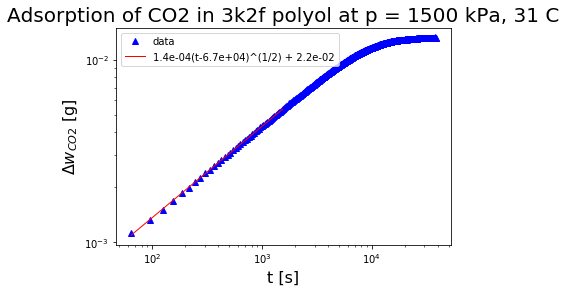

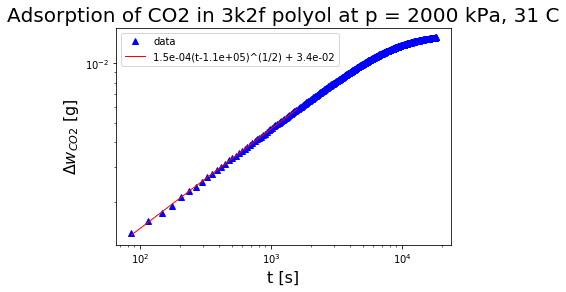

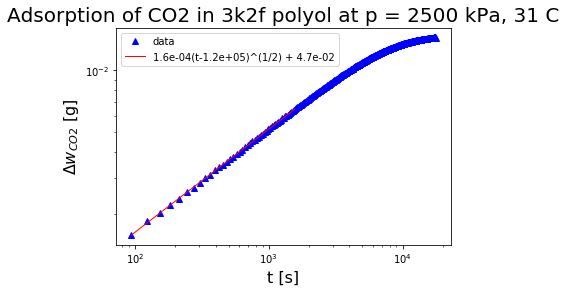

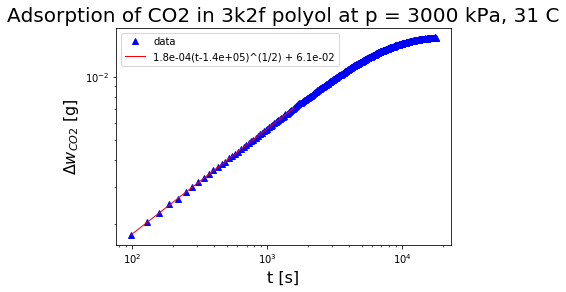

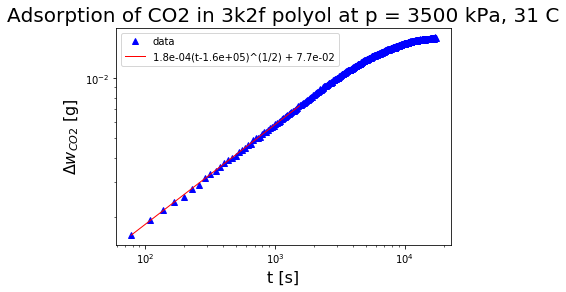

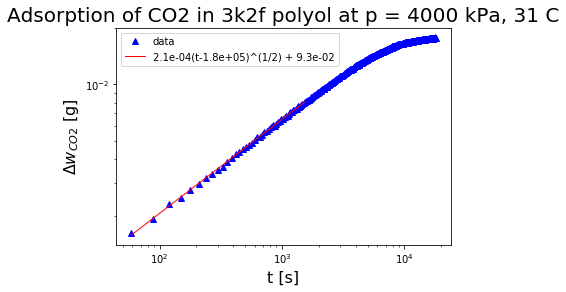

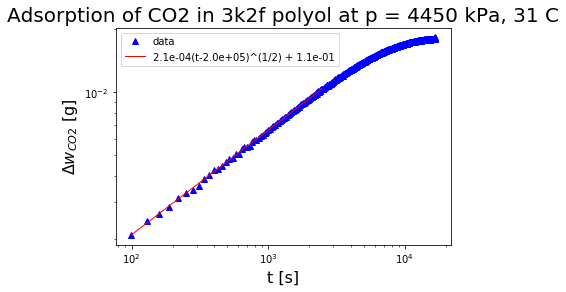

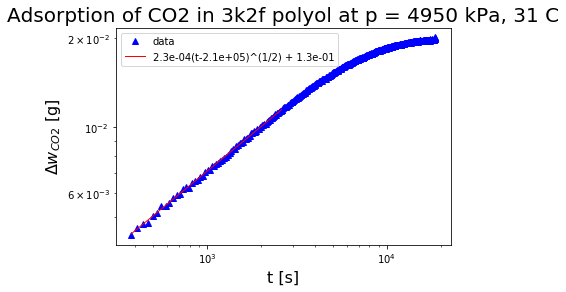

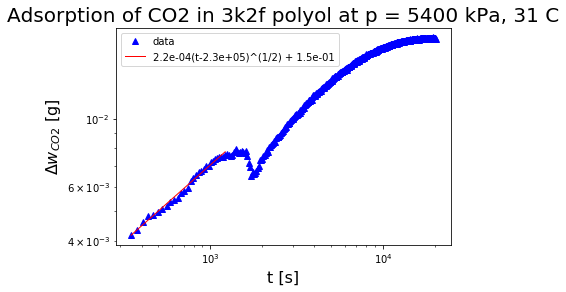

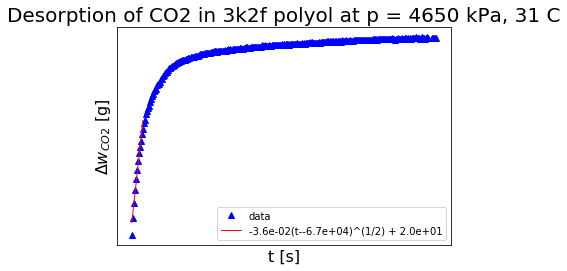

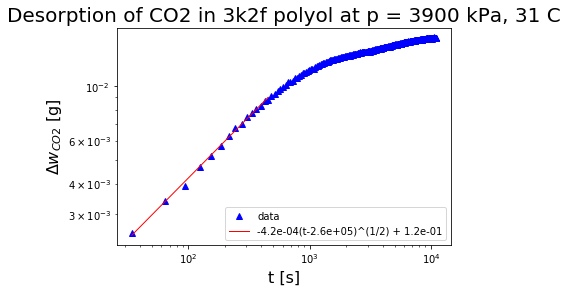

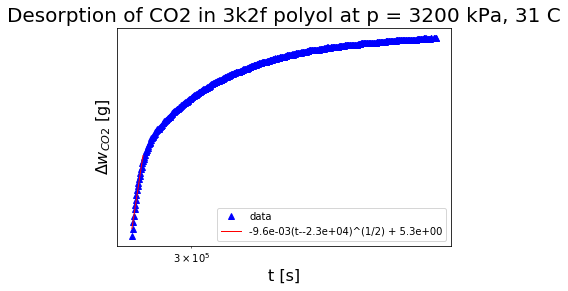

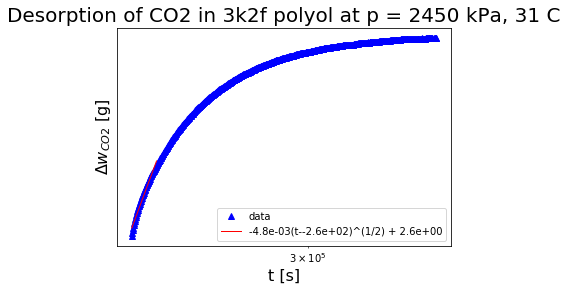

In [16]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 
reload(dataproc)
reload(plot)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[1] = 45
n_pts_sqrt_arr[2] = 40
n_pts_sqrt_arr[3] = 55
n_pts_sqrt_arr[12] = 80
n_pts_sqrt_arr[13] = 75
n_pts_sqrt_arr[14] = 30
n_pts_sqrt_arr[15] = 12
n_pts_sqrt_arr[16] = 15
n_pts_sqrt_arr[17] = 18
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = np.ones(len(p_set_arr)).astype(int)
i_shift[0] = 2
i_shift[1] = 15
i_shift[2] = 3
i_shift[3] = 3
i_shift[12] = 3
i_shift[13] = 10
i_shift[14] = 3 # huge fluctuation in mass during overshoot of pressure
i_shift[15] = 2
i_shift[16] = 10
i_shift[17] = 20
i_shift[18] = 2

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):   
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0 = t_grav[i_t0]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_3param, t_mp1[:n], w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    t0_fit = popt[2]
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100)
    w_fit = dataproc.square_root_3param(t_fit, a, w0, t0_fit)
    
    # plot the result to examine the fit
    is_adsorbing = i <= np.argmax(p_set_arr) and i != 0
    sign = 2*(is_adsorbing-0.5)
    stage = 'Adsorption' if is_adsorbing else 'Desorption'
    ax = plot.plot_line(t_mp1 - t0_fit, sign*(w_gas_act - w0), xlabel='t [s]', ylabel=r'$\Delta w_{CO2}$ [g]', 
                       title=stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T),
                             marker='^', label='data', xlog=True, ylog=True)
    ax = plot.plot_line(t_fit - t0_fit, sign*(w_fit - w0), ax=ax, marker=None, lw=1, color='r',
                        label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0_fit))
    plt.legend(loc='best')

    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = dataproc.square_root_3param(max(t0, t0_fit), a, w0, t0_fit)

Having computed the mean diffusivities, we will save them and plot the diffusivity as a function of the pressure.

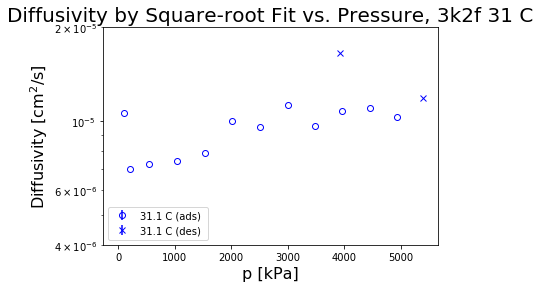

In [17]:
# record diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_arr
# record "initial" mass extrapolated to be at beginning of pressure quench
df['M_0 (extrap) [g]'] = M_0_extrap

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, 0.5*np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([4E-6, 2E-5])

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Model 1b: Fix t0 as the beginning of the change in pressure

Physically, the diffusion kinetics should follow a $t^{1/2}$ power law after the pressure changes, so the starting time $t_0$ should match the start of the change in pressure (roughly). In this method, we fix that point and fit the coefficient and intercept (two parameters free instead of the three free parameters from the previous section).

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 7.84e-02 cm^2/s.
t_init = 2520
t0 = 0
w0 = 0.0036600858230219383
Pressure = 50 kPa.
D_sqrt = 2.39e-05 cm^2/s.
t_init = 9660
t0 = 9270
w0 = -0.00011967418573291845
Pressure = 100 kPa.
D_sqrt = 1.48e-05 cm^2/s.
t_init = 13620
t0 = 13530
w0 = 0.00012417214427107374
Pressure = 200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.15e-05 cm^2/s.

C:\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "



t_init = 20010
t0 = 19590
w0 = 0.0006400557731837557
Pressure = 550 kPa.
D_sqrt = 9.77e-06 cm^2/s.
t_init = 30630
t0 = 30450
w0 = 0.0020008999293480594
Pressure = 1050 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.06e-05 cm^2/s.
t_init = 48540
t0 = 48270
w0 = 0.008882000391832534
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.10e-05 cm^2/s.
t_init = 67020
t0 = 66780
w0 = 0.02025077998955819
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.38e-05 cm^2/s.
t_init = 105360
t0 = 105090
w0 = 0.03249588453557171
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.35e-05 cm^2/s.
t_init = 123600
t0 = 123300
w0 = 0.04520215916342896
Pressure = 3000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.58e-05 cm^2/s.
t_init = 141510
t0 = 141210
w0 = 0.058969851594690745
Pressure = 3500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 1.78e-05 cm^2/s.
t_init = 159660
t0 = 159120
w0 = 0.072755429063205

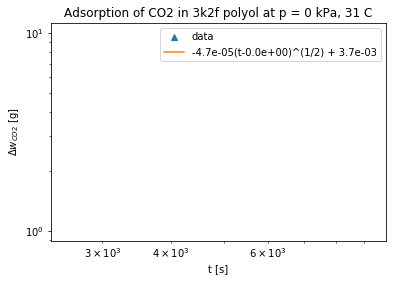

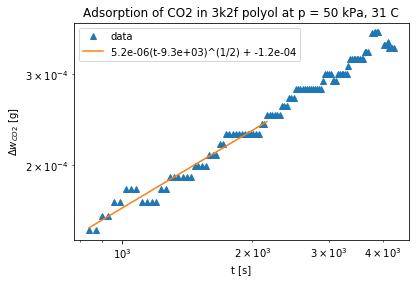

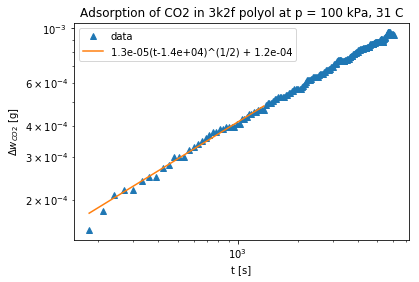

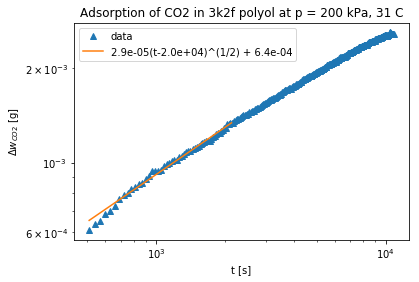

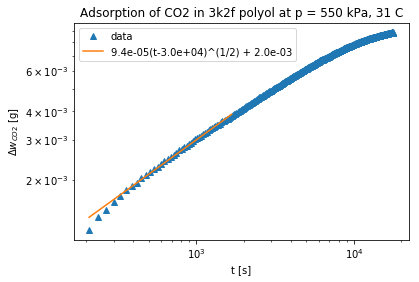

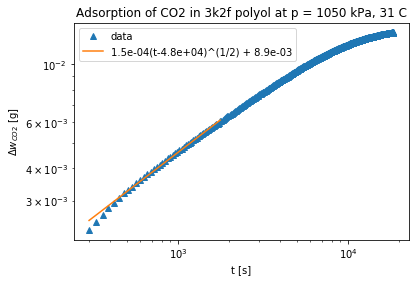

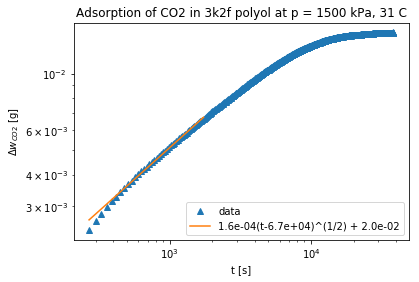

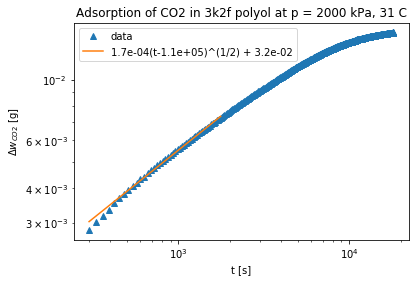

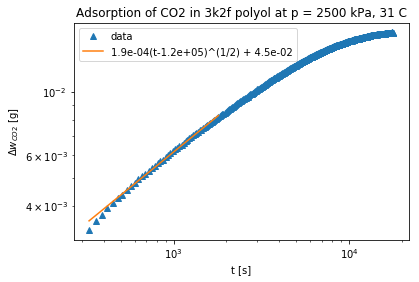

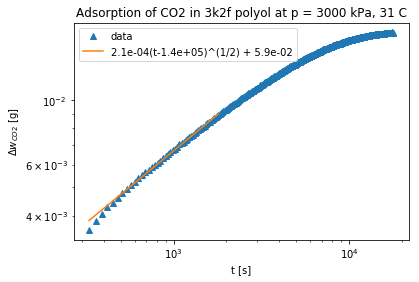

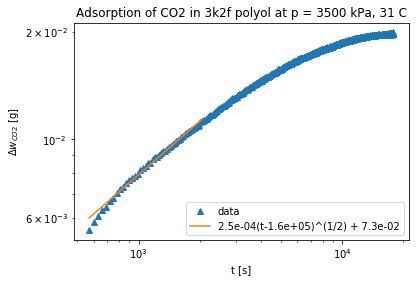

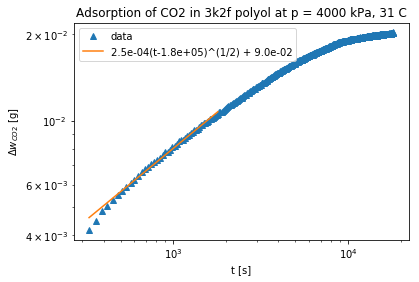

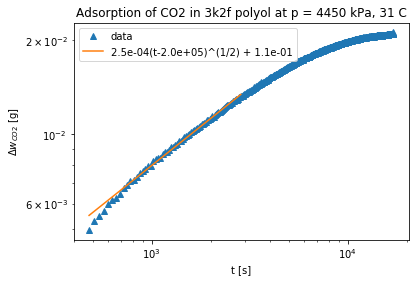

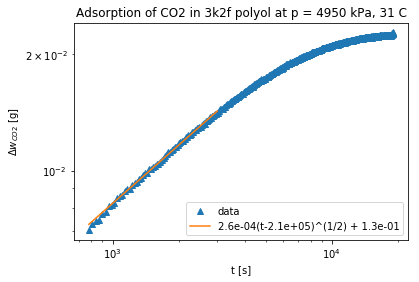

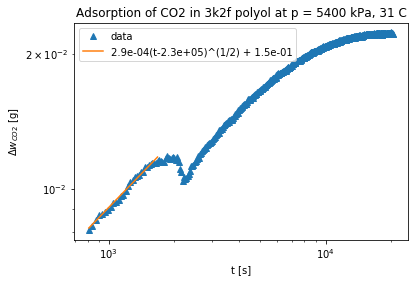

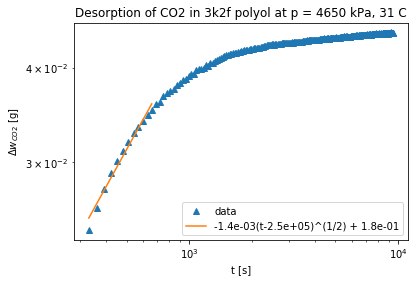

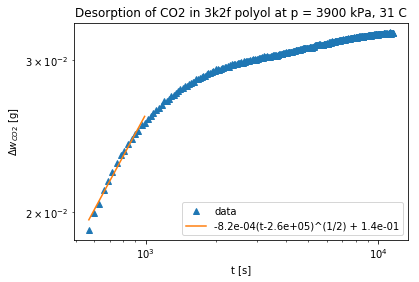

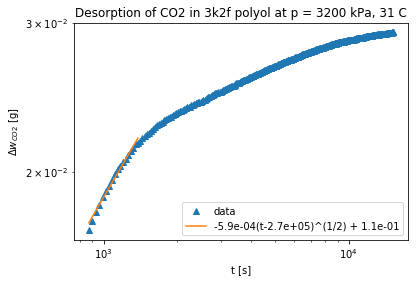

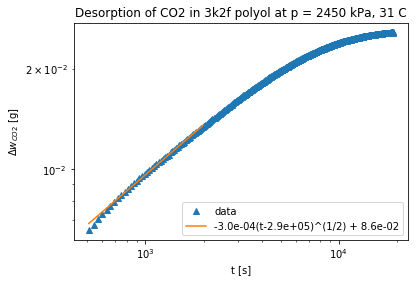

In [18]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 
reload(dataproc)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit


# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0 = t_grav[i_t0]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                 t_grav, p_thresh_frac, last_bound, v_ref_he, get_inst_buoy=True)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_2param, t_mp1[:n]-t0, w_gas_act[:n], maxfev=maxfev)
    a = popt[0]
    w0 = popt[1]
    
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100) - t0
    w_fit = dataproc.square_root_2param(t_fit, a, w0)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    M_0_extrap[i] = w0
    print('t_init = ' + str(t_init))
    print('t0 = ' + str(t0))
    print('w0 = ' + str(w0))

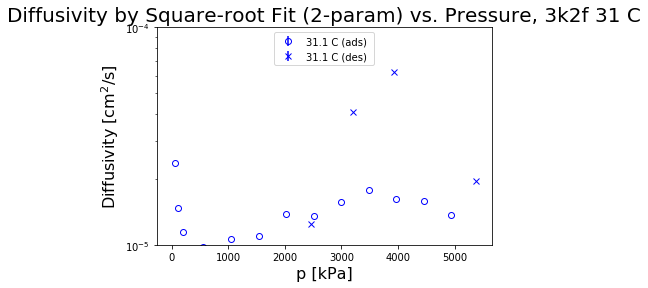

In [19]:
# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, 0.5*np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit (2-param) vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-5, 1E-4])
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_2param_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Model 1c: Fix Initial Time and Initial Mass

Julie suggested that I use the time at which the pressure begins to change as the initial time and the true mass of gas dissolved in the polyol as the initial mass for the $t^{1/2}$ fit. That way I am only fitting the coefficient $a$.

In [ ]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 
reload(dataproc)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit


# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0 = t_grav[i_t0]
    w0 = df['M_0 (prev) [g]'].iloc[i]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                 t_grav, p_thresh_frac, last_bound, v_ref_he, get_inst_buoy=True)
    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_1param, t_mp1[:n]-t0, w_gas_act[:n]-w0, maxfev=maxfev)
    a = popt[0]
    
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n-1], 100) - t0
    w_fit = dataproc.square_root_1param(t_fit, a) + w0
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # plot data translated such that first point is 0,0 and data increases (so t^1/2 looks like a straight line on log-log)
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    ax.loglog(t_mp1 - t0, sign*(w_gas_act - w0), '^', label='data')
    ax.loglog(t_fit, sign*(w_fit - w0), '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    
    # Also save the "initial" mass extrapolated to the beginning of the change in pressure
    print('t_init = ' + str(t_init))
    print('t0 = ' + str(t0))
    print('w0 = ' + str(w0))

Pressure = 0 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 9.08e-03 cm^2/s.
t_init = 289050
t0 = 0
w0 = 0.0
Pressure = 50 kPa.
D_sqrt = 9.15e-06 cm^2/s.
t_init = 289050
t0 = 9270
w0 = -4.184386835790261e-05
Pressure = 100 kPa.
D_sqrt = 7.97e-06 cm^2/s.
t_init = 289050
t0 = 13530
w0 = 0.00022373070882101667
Pressure = 200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.08e-06 cm^2/s.
t_init = 289050
t0 = 19590
w0 = 0.00107325824897246
Pressure = 550 kPa.
D_sqrt = 3.45e-06 cm^2/s.
t_init = 289050
t0 = 30450
w0 = 0.0032169611449279897
Pressure = 1050 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 3.72e-06 cm^2/s.
t_init = 289050
t0 = 48270
w0 = 0.010834918581510408
Pressure = 1500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.34e-06 cm^2/s.
t_init = 289050
t0 = 66780
w0 = 0.022206566844542596
Pressure = 2000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
D_sqrt = 4.83e-06 cm^2/s.
t_init = 289050
t0 = 105090
w0 = 0.03485100536854724
Pressure = 2500 

In [ ]:
# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr, 0.5*np.zeros([len(D_sqrt_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Square-root Fit (1-param) vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_1param_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

### Comparison of parameters for t^1/2 fitting

Below, I show the results of performing the fitting of the initial adsorption/desorption data to a $t^{1/2}$ curve for different fixed parameters of the fitting. Namely, I will test three different initial times $t_0$--(1) my best guess from above, (2) best guess minus 2 seconds, and (3) best guess plus 2 seconds--and I will compare using the estimate of $M_0$ from the $M_{\infty}$ of the previous test as the mass offset to the result from using the mass offset that yields the best fit. These plots will all correct for buoyancy using the instantaneous pressure.

In [ ]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 
reload(dataproc)
reload(plot)
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 50*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[15:18] = 10
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = 15*np.ones(len(p_set_arr)).astype(int)
i_shift[1] = 10
i_shift[13] = 10
i_shift[14] = 60 # huge fluctuation in mass during overshoot of pressure
i_shift[15] = 5
i_shift[16] = 5
i_shift[17] = 5
i_shift[18] = 2
# change in time between different t0's [s]
dt = 180
# lower bound of time to show on plots
t_min = 100
# bounds on change in mass
dw_min = 0.0001
dw_max = 0.05
# list of colors
color_list = ['m', 'c', 'r']
# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values when M0 is fixed and fitted
D_sqrt_arr_fixed = np.zeros([len(p_set_arr)])
D_sqrt_arr_fitted = np.zeros([len(p_set_arr)])
D_sqrt_arr_t0_fitted = np.zeros([len(p_set_arr)])
# initialize array to store initial mass M_0 extrapolated with t^1/2 fit
M_0_extrap = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    n_pts_sqrt = n_pts_sqrt_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    i_t0 = last_bound
    t0_list = [t_grav[i_t0], t_grav[i_t0]+dt, t_grav[i_t0]+2*dt]
    # get indices of each measurement with pressure within thresholds 
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    t_init = t_grav[i_p0]
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # additional cutting off of data for t^1/2 fit
    t_mp1 = t_mp1[i_shift[i]:]
    w_gas_act = w_gas_act[i_shift[i]:]
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    
    # METHOD 1: use the M_infty from the previous pressure (an estimate of M_0) as the mass offset [FIXED]
    w0 = df['M_0 (prev) [g]'].iloc[i]
    M_0 = w0
    M_infty = df['M_infty (final) [g]'].iloc[i]
    M_first = w_gas_act[0]
    # determine if system is adsorbing or desorbing
    is_adsorbing = i <= np.argmax(p_set_arr) and i != 0
    sign = 2*(is_adsorbing-0.5)
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for j in range(len(t0_list)):
        try:
            t0 = t0_list[j]
            n = min(n_pts_sqrt, len(t_mp1)-1)
            popt, pcov = curve_fit(dataproc.square_root_1param, t_mp1[:n] - t0, w_gas_act[:n] - w0, maxfev=maxfev)
            a = popt[0]
            # generate data points for t^(1/2) fit
            t_fit = np.linspace(t_min + t0, t_mp1[n-1], 100)
            w_fit = dataproc.square_root_1param(t_fit - t0, a) + w0

            # plot the result to examine the fit
            t_max = np.max(t_mp1) - t0
            stage = 'Adsorption' if is_adsorbing else 'Desorption'
            ax = plot.plot_line(t_mp1 - t0, sign*(w_gas_act - w0), xlabel=r'$t-t_0$ [s]', ylabel=r'$|M(t)-M_0|$ [g]',
                                     marker='^', label='data, t0 = %d s' % (t0), xlog=True, ylog=True, color=color_list[j], ax=ax)
            ax = plot.plot_line(t_fit - t0, sign*(w_fit - w0), ax=ax, marker=None, lw=1, color=color_list[j],
                                label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
            # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
            D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
            print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
            # store result for plotting
            if j==0:
                D_sqrt_arr_fixed[i] = D_sqrt
        except:
            print("Could not perform accurate fit on data for t0 + %d" % (i*dt))
        
    # plot the mass values of interest
#     ax = plot.plot_line([t_min, t_max], [M_0-w0, M_0-w0], color='g', marker=None, lw=1, ls='--', ax=ax, label=r'$M_0$')
    ax = plot.plot_line([t_min, t_max], [sign*(M_infty-w0), sign*(M_infty-w0)], color='b', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{\infty}$' + ' = %.5f g' % M_infty)
    ax = plot.plot_line([t_min, t_max], [sign*(M_first-w0), sign*(M_first-w0)], color='g', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{first}$' + ' = %.5f g' % M_first)
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C; fixed M0' % (polyol, p_set, T))
    # put legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    legend_x = 1
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))    
    # set axis limits
    ax.set_xlim([t_min, t_max])
#     ax.set_ylim([dw_min, dw_max])



    # METHOD 2: Fit the mass offset
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for j in range(len(t0_list)):
        t0 = t0_list[j]
        n = min(n_pts_sqrt, len(t_mp1)-1)
        popt, pcov = curve_fit(dataproc.square_root_2param, t_mp1[:n] - t0, w_gas_act[:n], maxfev=maxfev)
        a = popt[0]
        w0 = popt[1]
        # generate data points for t^(1/2) fit
        t_fit = np.linspace(t_min + t0, t_mp1[n-1], 100)
        w_fit = dataproc.square_root_2param(t_fit - t0, a, w0)

        # plot the result to examine the fit
        t_max = np.max(t_mp1) - t0
        stage = 'Adsorption' if is_adsorbing else 'Desorption'
        ax = plot.plot_line(t_mp1 - t0, sign*(w_gas_act - w0), xlabel=r'$t-t_0$ [s]', ylabel=r'$|M(t)-M_{0,fit}|$ [g]',
                                 marker='^', label='data, t0 = %d s' % (t0), xlog=True, ylog=True, color=color_list[j], ax=ax)
        ax = plot.plot_line(t_fit - t0, sign*(w_fit - w0), ax=ax, marker=None, lw=1, color=color_list[j],
                            label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=w0, t0=t0))
        # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
        D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
        print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
        # store result for plotting
        if j==0:
            D_sqrt_arr_fitted[i] = D_sqrt

        
    # plot the mass values of interest
    ax = plot.plot_line([t_min, t_max], [sign*(M_0-w0), sign*(M_0-w0)], color='k', marker=None, lw=1, ls='--', ax=ax, 
                        label=r'$M_0$' + ' =%.5f g' % M_0)
    ax = plot.plot_line([t_min, t_max], [sign*(M_infty-w0), sign*(M_infty-w0)], color='b', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{\infty}$' + ' = %.5f g' % M_infty)
    ax = plot.plot_line([t_min, t_max], [sign*(M_first-w0), sign*(M_first-w0)], color='g', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{first}$' + ' = %.5f g' % M_first)
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C; fitted M0' % (polyol, p_set, T))
    # put legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    legend_x = 1
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))    
    # set axis limits
    ax.set_xlim([t_min, t_max])
#     ax.set_ylim([dw_min, dw_max])


    # METHOD 3: Fit the initial time
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    n = min(n_pts_sqrt, len(t_mp1)-1)
    popt, pcov = curve_fit(dataproc.square_root_2param_t0_fit, t_mp1[:n], w_gas_act[:n] - M_0, maxfev=maxfev)
    a = popt[0]
    t0 = popt[1]
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_min + t0, t_mp1[n-1], 100)
    w_fit = dataproc.square_root_2param_t0_fit(t_fit, a, t0) + M_0

    # plot the result to examine the fit
    t_max = np.max(t_mp1) - t0
    stage = 'Adsorption' if is_adsorbing else 'Desorption'
    ax = plot.plot_line(t_mp1 - t0, sign*(w_gas_act - M_0), xlabel=r'$t-t_0$ [s]', ylabel=r'$|M(t)-M_0|$ [g]',
                             marker='^', label='data, t0 = %d s' % (t0), xlog=True, ylog=True, color=color_list[j], ax=ax)
    ax = plot.plot_line(t_fit - t0, sign*(w_fit - M_0), ax=ax, marker=None, lw=1, color=color_list[j],
                        label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=M_0, t0=t0))
    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result for plotting
    D_sqrt_arr_t0_fitted[i] = D_sqrt

        
    # plot the mass values of interest
    ax = plot.plot_line([t_min, t_max], [sign*(M_infty-M_0), sign*(M_infty-M_0)], color='b', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{\infty}$' + ' = %.5f g' % M_infty)
    ax = plot.plot_line([t_min, t_max], [sign*(M_first-M_0), sign*(M_first-M_0)], color='g', marker=None, lw=1, ax=ax, 
                        ls='--', label=r'$M_{first}$' + ' = %.5f g' % M_first)
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C; fitted t0' % (polyol, p_set, T))
    # put legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    legend_x = 1
    legend_y = 0.5
    plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))    
    # set axis limits
    ax.set_xlim([t_min, t_max])
#     ax.set_ylim([dw_min, dw_max])

In [ ]:
# Plot diffusivity vs. pressure for fixed M_0 and t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_fitted, np.zeros([len(D_sqrt_arr_fitted)]), p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='fixed M0',
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# Plot diffusivity vs. pressure for fitted M_0 and fixed t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_fixed, np.zeros([len(D_sqrt_arr_fixed)]), p_set_arr, T, ax=ax, color='g',
                                label_tag='fitted M0') 
# Plot diffusivity vs. pressure for fixed M_0 and fitted t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_t0_fitted, np.zeros([len(D_sqrt_arr_t0_fitted)]), p_set_arr, T, ax=ax, 
                                 color='k', label_tag='fitted t0') 

save_plots=False
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fixed_fitted_t0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

***DEMONSTRATE THAT CHANGE IN H_SAMP IS NEGLIGIBLE (HOW SMALL?)***

In [ ]:
# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 

# set number of points for exponential fit
n_pts_exp_arr = 120*np.ones([len(p_set_arr)]).astype(int)
n_pts_exp_arr[1] = 80
n_pts_exp_arr[4] = 150
n_pts_exp_arr[6] = 750
n_pts_exp_arr[7] = 180
n_pts_exp_arr[8] = 180
n_pts_exp_arr[9] = 180
n_pts_exp_arr[11] = 210
n_pts_exp_arr[12] = 250
n_pts_exp_arr[13] = 230
n_pts_exp_arr[14] = 210
n_pts_exp_arr[15] = 180
n_pts_exp_arr[16] = 180
n_pts_exp_arr[18] = 210
# set shift of end point
i_shift_exp_arr = -np.ones([len(p_set_arr)]).astype(int)
i_shift_exp_arr[4] = -5
i_shift_exp_arr[6] = -125
i_shift_exp_arr[11] = -10
i_shift_exp_arr[12] = -50
i_shift_exp_arr[13] = -10
i_shift_exp_arr[16] = -15

# initalize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    n_pts_exp = n_pts_exp_arr[i]
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
    # shift time to start at t = 0
    i_shift_exp = i_shift_exp_arr[i]
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[-n_pts_exp:i_shift_exp]-t_mp1[-n_pts_exp], 
                           w_gas_act[-n_pts_exp:i_shift_exp], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[-n_pts_exp], t_mp1[-1], 100) - t_mp1[-n_pts_exp]
    w_fit = dataproc.exponential_approach(t_fit, a, b, c)
    
    # plot the result to examine the fit
    is_adsorbing = i <= np.argmax(p_set_arr)
    sign = 2*(is_adsorbing-0.5)
    stage = 'Adsorption' if is_adsorbing else 'Desorption'
    ax = plot.plot_line(t_mp1[:i_shift_exp], np.abs(c - w_gas_act[:i_shift_exp]), xlabel='t [s]', 
                        ylabel=r'$M_{\infty} - M_{CO2}$ [g]', 
                       title=stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T),
                             marker='^', label='data', xlog=True, ylog=True)
    ax = plot.plot_line(t_fit + t_mp1[-n_pts_exp], np.abs(c - w_fit), ax=ax, marker=None, lw=1, color='r',
                        label=r'{a:.1e}exp({b:.1e}t); $M_\infty=${c:.1e}'.format(a=a, b=b, c=c))
    ax.tick_params(axis='y', which='minor', left=True)
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp
    # Store mass estimated at time --> infinity
    M_infty_arr[i] = c
    # store fitted exponential time constant [s]
    tau_arr[i] = -1/b

Note that `get_inst_buoy=True` makes the program correct for buoyancy at the (approximately) instantaneous conditions of each data point. This greatly reduces the fluctuations at the end of the solubility curve.

Below we adjust the range.

In [ ]:
# initalize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    is_adsorbing = (i <= np.argmax(p_set_arr)) and p_set != 0

    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
     
    if p_set == 0 or p_set == 50:
        continue
        
    #### NEW ####
    # normalize
    if is_adsorbing:
        M_infty = np.max(w_gas_act)
        M_0 = np.min(w_gas_act)
    else:
        M_infty = np.min(w_gas_act)
        M_0 = np.max(w_gas_act)    
    w_gas_norm = np.abs((M_infty - w_gas_act) / (M_infty - M_0))
    i_50 = np.where(w_gas_norm > 0.1)[0][-1]
    i_90 = np.where(w_gas_norm > 0.02)[0][-1]
    #############
    
    # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
    # shift time to start at t = 0
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[i_50:i_90]-t_mp1[i_50], 
                           w_gas_act[i_50:i_90], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[i_50], t_mp1[i_90], 100) - t_mp1[i_50]
    w_gas_fit = dataproc.exponential_approach(t_fit, a, b, c)
    
    # plot the result to examine the fit
    normalization = 1 / np.max(np.abs(c - w_gas_act))
    w_gas_2_plot = normalization*np.abs(c - w_gas_act)
    w_fit_2_plot = normalization*np.abs(c - w_gas_fit)
    
    #Plot diffusivity vs. p    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.semilogy(t_mp1, w_gas_2_plot, '^', label='data')
    ax.semilogy(t_fit + t_mp1[i_50], w_fit_2_plot, '-', label=r'{a:.1e}exp({b:.1e}t); $M_\infty=${c:.1e}' \
                .format(a=a, b=b, c=c))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$M_{\infty} - M_{CO2} / M_{\infty} - M_0$ [g]')
    ax.tick_params(axis='y', which='minor', left=True)
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp
    
    # Store mass estimated at time --> infinity
    M_infty_arr[i] = c
    # store fitted exponential time constant [s]
    tau_arr[i] = -1/b

In [ ]:
#### TRY REDOING MARKING OF BOUNDARIES TO GET THEM TO CONVERGE

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    is_adsorbing = (i <= np.argmax(p_set_arr)) and p_set != 0

    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
     
    if p_set == 0 or p_set == 50:
        continue
        
    #### NEW ####
    # normalize
    if is_adsorbing:
        M_infty = np.max(w_gas_act)
        M_0 = np.min(w_gas_act)
    else:
        M_infty = np.min(w_gas_act)
        M_0 = np.max(w_gas_act)    
    w_gas_norm = np.abs((M_infty - w_gas_act) / (M_infty - M_0))
    i_50 = np.where(w_gas_norm > 0.1)[0][-1]
    i_90 = np.where(w_gas_norm > 0.02)[0][-1]
    #############
    
    # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
    # shift time to start at t = 0
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[i_50:i_90]-t_mp1[i_50], 
                           w_gas_act[i_50:i_90], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[i_50], t_mp1[i_90], 100) - t_mp1[i_50]
    w_gas_fit = dataproc.exponential_approach(t_fit, a, b, c)
    
    # plot the result to examine the fit
    normalization = 1 / np.max(np.abs(c - w_gas_act))
    w_gas_norm = normalization*np.abs(c - w_gas_act)
    
    try:
        i_50 = np.where(w_gas_norm > 0.15)[0][-1]
        i_90 = np.where(w_gas_norm > 0.04)[0][-1]

        # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
        # shift time to start at t = 0
        popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[i_50:i_90]-t_mp1[i_50], 
                               w_gas_act[i_50:i_90], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
        a, b, c = popt

        # generate data points for exponential fit
        t_fit = np.linspace(t_mp1[i_50], t_mp1[i_90], 100) - t_mp1[i_50]
        w_gas_fit = dataproc.exponential_approach(t_fit, a, b, c)

        # plot the result to examine the fit
        normalization = 1 / np.max(np.abs(c - w_gas_act))
        w_gas_2_plot = normalization*np.abs(c - w_gas_act)
        w_fit_2_plot = normalization*np.abs(c - w_gas_fit)

        #Plot diffusivity vs. p    
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.semilogy(t_mp1, w_gas_2_plot, '^', label='data')
        ax.semilogy(t_fit + t_mp1[i_50], w_fit_2_plot, '-', label=r'{a:.1e}exp({b:.1e}t); $M_\infty=${c:.1e}' \
                    .format(a=a, b=b, c=c))
        ax.set_xlabel('t [s]')
        ax.set_ylabel(r'$M_{\infty} - M_{CO2} / M_{\infty} - M_0$ [g]')
        ax.tick_params(axis='y', which='minor', left=True)
        if is_adsorbing:
            stage = 'Adsorption'
        else:
            stage = 'Desorption'
        ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
        plt.legend(loc='best')

        D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
        print('D_exp = %.2e cm^2/s.' % D_exp)
        # store result
        D_exp_arr[i] = D_exp

        # Store mass estimated at time --> infinity
        M_infty_arr[i] = c
        # store fitted exponential time constant [s]
        tau_arr[i] = -1/b
    except:
        print('error with second iteration.')

In [ ]:
#### TRY REDOING MARKING OF BOUNDARIES TO GET THEM TO CONVERGE

# FOR REFERENCE
# p_set_arr = np.array([0:0, 1:50, 2:100, 3:200, 4:550, 5:1050, 6:1500, 7:2000, 8:2500, 9:3000, 10:3500, 11:4000, 12:4450,
#                        13:4950, 14:5400, 15:4650, 16:3900, 17:3200, 18:2450]) 

# initialize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# initialize array of extrapolated mass at t --> infinity
M_infty_arr = np.zeros([len(p_set_arr)])
# initialize array to store fitted exponential time constants [s]
tau_arr = np.zeros([len(p_set_arr)])
# thresholds for fraction of remaining gas mass to include in fit
thresh0 = 0.15*np.ones([len(p_set_arr)])
thresh1 = 0.04*np.ones([len(p_set_arr)])
# individualized thresholds
thresh0[2] = 0.6 # 100 kPa
thresh1[2] = 0.4 # 100 kPa
thresh0[3] = 0.4 # 200 kPa
thresh1[3] = 0.2 # 200 kPa
thresh0[15] = 0.08 # 4650 kPa
thresh1[15] = 0.02 # 4650 kPa
thresh0[16] = 0.1 # 3900 kPa
thresh1[16] = 0.02 # 3900 kPa

# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    is_adsorbing = (i <= np.argmax(p_set_arr)) and p_set != 0

    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
     
    if p_set == 0 or p_set == 50:
        continue
        
    #### NEW ####
    # normalize
    if is_adsorbing:
        M_infty = np.max(w_gas_act)
        M_0 = np.min(w_gas_act)
    else:
        M_infty = np.min(w_gas_act)
        M_0 = np.max(w_gas_act)    
    w_gas_norm = np.abs((M_infty - w_gas_act) / (M_infty - M_0))
    i_exp0 = np.where(w_gas_norm > thresh0[i])[0][-1]
    i_exp1 = np.where(w_gas_norm > thresh1[i])[0][-1]
    #############
    
    # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
    # shift time to start at t = 0
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[i_exp0:i_exp1]-t_mp1[i_exp0], 
                           w_gas_act[i_exp0:i_exp1], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[i_exp0], t_mp1[i_exp1], 100) - t_mp1[i_exp0]
    w_gas_fit = dataproc.exponential_approach(t_fit, a, b, c)
    
    # plot the result to examine the fit
    normalization = 1 / np.max(np.abs(c - w_gas_act))
    w_gas_norm = normalization*np.abs(c - w_gas_act)
    
    try:
        i_exp0 = np.where(w_gas_norm > thresh0[i])[0][-1]
        i_exp1 = np.where(w_gas_norm > thresh1[i])[0][-1]

        # fit initial data points to an exponential curve per eqn 10.168 in Crank (1956) "The Mathematics of Diffusion"
        # shift time to start at t = 0
        popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[i_exp0:i_exp1]-t_mp1[i_exp0], 
                               w_gas_act[i_exp0:i_exp1], maxfev=maxfev, p0=(-0.01, -0.01, 0.1))
        a, b, c = popt

        # generate data points for exponential fit
        t_fit = np.linspace(t_mp1[i_exp0], t_mp1[i_exp1], 100) - t_mp1[i_exp0]
        w_gas_fit = dataproc.exponential_approach(t_fit, a, b, c)

        # plot the result to examine the fit
        normalization = 1 / np.max(np.abs(c - w_gas_act))
        w_gas_2_plot = normalization*np.abs(c - w_gas_act)
        w_fit_2_plot = normalization*np.abs(c - w_gas_fit)

        #Plot diffusivity vs. p    
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.semilogy(t_mp1, w_gas_2_plot, '^', label='data')
        ax.semilogy(t_fit + t_mp1[i_exp0], w_fit_2_plot, '-', label=r'{a:.1e}exp({b:.1e}t); $M_\infty=${c:.1e}' \
                    .format(a=a, b=b, c=c))
        ax.set_xlabel('t [s]')
        ax.set_ylabel(r'$M_{\infty} - M_{CO2} / M_{\infty} - M_0$ [g]')
        ax.tick_params(axis='y', which='minor', left=True)
        if is_adsorbing:
            stage = 'Adsorption'
        else:
            stage = 'Desorption'
        ax.set_title(stage + ' of CO2 in %s polyol at p = %d kPa, %d C' % (polyol, p_set, T))
        plt.legend(loc='best')

        D_exp = dataproc.compute_D_exp(i, diam_cruc, df, b)
        print('D_exp = %.2e cm^2/s.' % D_exp)
        # store result
        D_exp_arr[i] = D_exp

        # Store mass estimated at time --> infinity
        M_infty_arr[i] = c
        # store fitted exponential time constant [s]
        tau_arr[i] = -1/b
    except:
        print('error with second iteration.')

In [ ]:
# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, 0.5*np.zeros([len(D_exp_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# save figure
save_plots = False
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

In [ ]:
# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, 0.5*np.zeros([len(D_exp_arr)]), p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', label_tag='exp',
                                 title='Diffusivity vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_arr_t0_fitted, 0.5*np.zeros([len(D_exp_arr)]), p_set_arr, T, ax=ax, color='g', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='sqrt')
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# save figure
save_plots = True
if save_plots:
    plt.savefig(save_folder + 'diff_exp_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

In [ ]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)